<a href="https://colab.research.google.com/github/s-c-soma/AdvanceDeeplearning-CMPE-297/blob/master/Assignment_6/Assignment_6a_Autograd_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement complete autograd framework in python and numpy  and mnist classifier using the autograd framework



## Implementation Details and Discussion

* This colab implements the autograd framework in python, numpy and mnist classifier using autograd framework. I have also studied and followed Professor's given reference to understand the approach.

* Here I have followed the steps following reference colab provided by Professor:
> 1. Loaded the MNIST data
> 2. Some preprocessing and normalization
> 3. The defined the Autograd class
> 4. Then I have trained the classifier model using autograd in it
> 5. Finally I have done some prediction
> 6. At the last I have done some unit testing on autograd as well




# Check if GPU/TPU available

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  1 05:35:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# import libraries

In [3]:
# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
import itertools
import math
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Load Data- MNIST



In [4]:
# Read in the Mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


# Visualize the dataset

In [5]:

def visualize_N_elems_of_dataset(dataset, N, name):
  print("Visualizing the " + name + " dataset.")
  fig = plt.figure(figsize=plt.figaspect(0.3))

  # Plot N elems of the dataset
  for image in range(0, N):
    ax = fig.add_subplot(1, 10, image+1)
    ax.imshow(dataset[image], cmap='Accent')

Visualizing the train dataset.


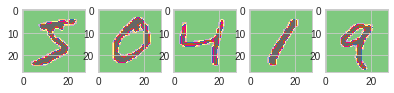

In [11]:
N = 5
visualize_N_elems_of_dataset(X_train, N, "train")

Visualizing the test dataset.


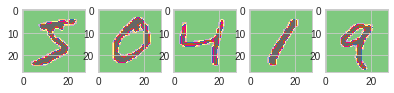

In [9]:
N = 5
visualize_N_elems_of_dataset(X_train, N, "test")

# Preprocessing

In [12]:
from keras.utils import np_utils
X_train = X_train.reshape(X_train.shape[0], 28*28) / 255.
X_test = X_test.reshape(X_test.shape[0], 28*28) / 255.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Train- Testing Split

In [13]:
X_train = X_train[:10]
y_train = y_train[:10]
X_test = X_test[:100]
y_test = y_test[:100]
input_dim = X_train.shape[1]
num_classes = y_test.shape[1]

# Autograd

In [14]:
class AutoGradTensor:

    def __init__(self, data, autograd=False):
        self.data = data
        if not isinstance(data, np.ndarray):
            self.data = np.array(data)
        # whether to run backpropagation or not
        self.autograd = autograd
        # tensor gradient
        self._grad = None
        # operation if this tensor was used in it
        self._grad_fn = None

    # Use Python Decorator @property to properly set the  
    @property
    def shape(self):
        return self.data.shape

    @property
    def grad_fn(self):
        if not self.autograd:
            raise Exception('This tensor is not backpropagated')
        return self._grad_fn

    @property
    def grad(self):
        return self._grad

    def backward(self, grad=None):
        if not self.grad_fn:
            return False

        if grad is None and self._grad is None:
            # in case if this is last loss tensor
            grad = self.__class__(1., requires_grad=False)

        elif self.grad is not None:
            grad = self._grad

        if not self.autograd:
            raise Exception('This tensor is not backpropagated')

        self.grad_fn.backward(grad)
        return True

    def __str__(self):
        return f'AutoGradTensor({str(self.data)})'

    def add_grad(self, grad):
        if self._grad is None:
            self._grad = grad
        else:
            self._grad += grad

    def __add__(self, o): 
        if self.data is not None:
            self.data += o.data  
            return self
        self.data = o.data 
        return self

    def model(self, x):
        if(self.autograd):
            return AutoGradTensor(self.data.dot(x.data))
        return AutoGradTensor(self.data.dot(x.data))

class Operation:

    def forward(self):
        raise NotImplemented

    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        self.out = self.forward(*args)
        self.out._grad_fn = self
        return self.out

class Add(Operation):

    '''Summation operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        # created tensor should be backpropagated if at least one 
        # of the input is backpropagated
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data + y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            # as we have matrix operation one of the parameters can have partial shape
            # in such scenarion we need to sum gradient values by missed axis
            if self.x.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.x.shape) - np.array(grad.shape)))
                self.x.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.x.add_grad(grad)
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            if self.y.shape != grad.shape:
                axis = np.argmax(np.abs(np.array(self.y.shape) - np.array(grad.shape)))
                self.y.add_grad(Tensor(grad.data.sum(axis=axis, keepdims=True)))
            else:
                self.y.add_grad(grad)
            if self.y.grad_fn:
                self.y.backward()

class Multiplication(Operation):
    '''Multiplication operation of x and y tensors'''

    def forward(self, x: AutoGradTensor, y: AutoGradTensor):
        self.x = x
        self.y = y
        autograd = x.autograd or y.autograd
        return AutoGradTensor(x.data * y.data, autograd=autograd)

    def backward(self, grad):
        if self.x.autograd:
            self.x.add_grad(AutoGradTensor(grad.data * self.y.data, False))
            if self.x.grad_fn:
                self.x.backward()
        if self.y.autograd:
            self.y.add_grad(AutoGradTensor(grad.data * self.x.data, False))
            if self.y.grad_fn:
                self.y.backward()

In [22]:
def add(x, y):
  z = x + y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [1, 1, 1, 1, 1])
  return z

In [23]:
def subtract(x, y):
  z = x - y
  z.backward(Tensor(np.array([1, 1, 1, 1, 1])))
  np.testing.assert_array_equal(x.grad.data, [1, 1, 1, 1, 1])
  np.testing.assert_array_equal(y.grad.data, [-1, -1, -1, -1, -1])
  return z

In [15]:
# Define the class Tensor
class Tensor (object):
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = FloatTensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if self.creation_op == "softmax":
                    self.creators[0].backward(self.grad)

                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):
        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def shape(self):
      return self.data.shape
    
    def softmax(self):
        x = self.data - self.data.max(axis=1, keepdims=True)
        y = np.exp(x)
        v = y / y.sum(axis=1, keepdims=True)

        if(self.autograd):
            return Tensor(v,
                          autograd=True,
                          creators=[self],
                          creation_op="softmax")
        return Tensor(v)

    def cross_entropy(self, target_indices):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  


# Network Build with Autograd

In [17]:
class Layer:

    def forward(self):
        raise NotImplemented
    
    def backward(self, grad):
        raise NotImplemented

    def __call__(self, *args):
        return self.forward(*args)

class Sigmoid:

    def forward(self, x):
        self.x = x   
        return 1/(1+np.exp(-x))
      
    def backward(self, grad):
        grad_input = self.x*(1-self.x) * grad
        return grad_input

class Relu(Layer):

    def forward(self,x):
        self.x = x
        return np.maximum(np.zeros_like(x), x)
      
    def backward(self, grad):
        grad_input = (self.x > 0) * grad
        return grad_input

# Create Softmax Cross Entropy Activation Function
class SoftmaxCrossentropyWithLogits(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y

        exps = np.exp(x) 
        self.softmax = exps / np.sum(exps, axis=-1, keepdims=True)

        logits = self.softmax[np.arange(x.shape[0]),y]
        log_likelihood = -np.log(logits)
        loss = np.sum(log_likelihood) / x.shape[0]
        return loss
    # Setting the grad = True will call the autograd function in AutoGradTensor
    def backward(self, grad=True):
        batch = self.x.shape[0]
        grad = self.softmax
        grad[np.arange(batch),self.y] -= 1
        grad = grad/batch
        return grad

class MSE(Layer):

    def forward(self, x, y):
        self.x = x
        self.y = y
        return ((x - y)**2) / (self.x.shape[0]*2)

    def backward(self, grad=None):
        # 1/2n * Sum(xi-yi)**2 
        # dx = 1/2n * Sum( x**2 -2*x*y + y**2) 
        # dx  = (2x - 2y) / 2*n = (x - y) / n
        return (self.x - self.y) / self.x.shape[0]

class Linear(Layer):

    def __init__(self, input, output, lr=0.0001):
        self.A = 2*np.random.random((input, output)) - 1
        self.b = 2*np.random.random((output)) - 1
        self.lr = lr
    
    def forward(self, x):
        self.x = x
        return np.dot(x,self.A) + self.b

    def backward(self, grad):
        # d_layer / db = 1
        b_grad = grad.mean(axis=0)*self.x.shape[0]
        # d_layer / dA = x
        A_grad = np.dot(self.x.T, grad)
        # As this layer have somee weights we need to update them using gradient descent
        # compute df / dx = df / d_layer * d_layer / dx
        # df / d_layer == grad
        grad_input = np.dot(grad, self.A.T)
        
        self.A -= A_grad * self.lr
        self.b -= b_grad * self.lr

        return grad_input

# Model Fit and Prediction

In [16]:
# set up data
data = Tensor(X_train, autograd=True)
expected = Tensor(y_train, autograd=True)

weights = []
weights.append(Tensor(np.random.rand(input_dim, 64), autograd=True))
weights.append(Tensor(np.random.rand(64, 10), autograd=True))
learning_rate = 0.0001

# fit, predict
for i in range(10):
  # Predict
  predicted = data.mm(weights[0]).mm(weights[1]).softmax()
  loss = ((predicted - expected) * (predicted - expected)).sum(0)
  loss.backward(Tensor(np.ones_like(loss.data)))
  for wts in weights:
    wts.data -= wts.grad.data*learning_rate
    wts.grad.data = wts.grad.data*0
    print(np.mean(loss.data))

1.7999998884235346
1.7999998884235346
1.5977791192740975
1.5977791192740975
1.2551492354641802
1.2551492354641802
1.8
1.8
1.573028243794248
1.573028243794248
1.4
1.4
1.6995788484728986
1.6995788484728986
1.5459581985532598
1.5459581985532598
1.7997821701675776
1.7997821701675776
1.8
1.8


In [18]:
# Load MNIST using Pytorch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

class Model(Layer):

    def __init__(self, lr=0.00001):
        self.lr = lr
        self.layers = [
            Linear(784,100, lr=self.lr),
            Relu(),
            Linear(100,200, lr=self.lr),
            Relu(),
            Linear(200,10, lr=self.lr)        
        ]

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self, grad):
        for l in self.layers[::-1]:
            grad = l.backward(grad)

        return grad


simple = transforms.Compose([
    transforms.ToTensor(), # converts to [0,1] interval
])
ds = MNIST('./mnist', download=True, transform=simple)
ld = DataLoader(ds, batch_size=2, pin_memory=True, drop_last=True) 

mm = Model()
loss = SoftmaxCrossentropyWithLogits()
_loss_avg = 0 
for e in range(7):
    for i, (img, label) in enumerate(ld):
        # convert the image to Numpy array
        x = img.view(2,-1).numpy()

        y = mm(x)
        # convert the label to numpy array
        _loss = loss(y, label.numpy())
        _loss_avg += _loss.mean() # running loss mean
        grad = loss.backward(1)
        mm.backward(grad)

        if i % 100 == 0:
            print(_loss_avg/100)
            _loss_avg = 0
            print('---------')

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Processing...
Done!
1.1736088199381742
---------
157.35178820561438
---------
149.1340200084009
---------
148.16771535628754
---------
150.99724974614367
---------
143.52459675907204
---------
124.45108543599221
---------
131.75060216556273
---------
132.22779082044062
---------
124.37335373690559
---------
123.64083017743327
---------
113.643995947415
---------
110.34551261344133
---------
98.4700157194557
---------
114.08887014036763
---------
98.71974231767946
---------
92.04949739392407
---------
92.817397577881
---------
94.89553433332756
---------
94.06968851641146
---------
91.9324706575654
---------
96.4126647314858
---------
86.33297382163728
---------
85.8977094814862
---------
93.62166870399909
---------
93.98071989963489
---------
95.10165192870592
---------
86.2730477956697
---------
79.27328976523755
---------
82.0540517874444
---------
70.8280284086547
---------
72.89465317968447
---------
79.4

# Prediction Using MNIST

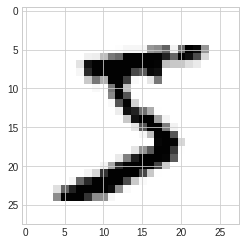

target: 5 predicted: 5


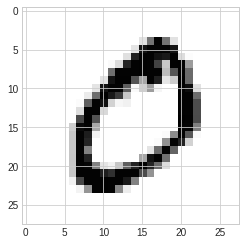

target: 0 predicted: 0


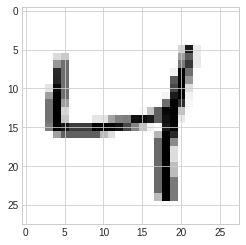

target: 4 predicted: 4


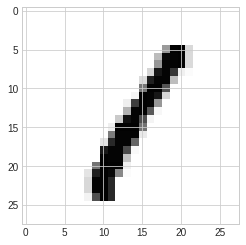

target: 1 predicted: 1


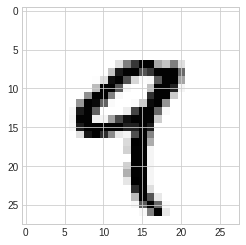

target: 9 predicted: 4


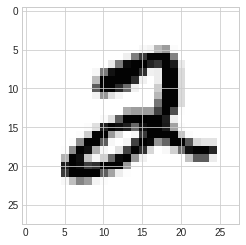

target: 2 predicted: 2


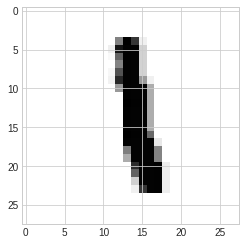

target: 1 predicted: 1


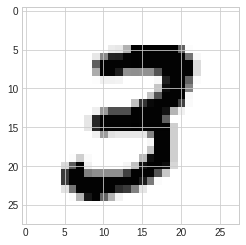

target: 3 predicted: 3


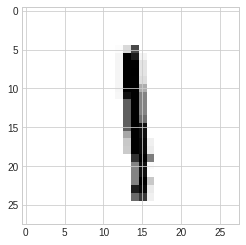

target: 1 predicted: 1


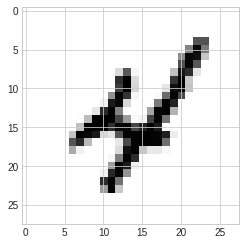

target: 4 predicted: 4


In [19]:
import matplotlib.pyplot as plt

for i in range(10):
    img, target = ds[i]
    plt.imshow(img[0])
    plt.show()
    x = img.view(1,-1).numpy()
    res = mm(x)[0]
    pred = np.argmax(res)
    print(f'target: {target} predicted: {pred}' )

# Unit Testing

## Autograd Multiplication

In [20]:
x = np.random.random((3,3))
a = np.random.random((3,3))
b = np.random.random((3,))

loss = np.random.random((3,3))

_x = AutoGradTensor(x,autograd=True)
_a = AutoGradTensor(a,autograd=True)
_b = AutoGradTensor(b,autograd=True)

y = Multiplication()(Add()(Multiplication()(_x, _a), _b), _a)
print('y = ', y)
print('___________________________________________________________')
y.backward(AutoGradTensor(loss))
print('_x.grad = ',_x.grad)
print('___________________________________________________________')
print('_a.grad = ',_a.grad) 
print('___________________________________________________________')
print('_b.grad = ',_b.grad) 

y =  AutoGradTensor([[0.0651679  0.3004307  0.66646674]
 [0.32091486 0.01139301 1.09123747]
 [0.29019748 0.42528395 1.22002139]])
___________________________________________________________
_x.grad =  AutoGradTensor([[0.00757726 0.23299522 0.05521466]
 [0.27511181 0.00065124 0.19611046]
 [0.25050168 0.21315042 0.25050753]])
___________________________________________________________
_a.grad =  AutoGradTensor([[0.17779726 0.09158931 0.11918338]
 [0.39252854 0.18642696 0.86514484]
 [0.61513319 0.94945975 0.86585559]])
___________________________________________________________
_b.grad =  [[0.93415425 0.67063642 0.67879608]]


## Autograd Add

In [24]:
x = Tensor([5, 6, 3, 4, 5], autograd=True)
y = Tensor([2, 5, 9, 1, 0], autograd=True)
z = add(x, y)
z

array([ 7, 11, 12,  5,  5])

## Autograd Subtract

In [25]:
x = Tensor([9, 1, 5, 8, 9], autograd=True)
y = Tensor([1, 1, 6, 1, 1], autograd=True)
z = subtract(x, y)
z

array([ 8,  0, -1,  7,  8])